# Kje naj danes kolesarim?
## Geografska analiza rekreativnega kolesarjenja v Sloveniji
---
Urejanje trenutnih podatkov v neki srednji obliki iz strave (detailed_segments.json)

In [68]:
import json
from shapely.geometry import Point
from shapely.geometry import shape
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
# Trenutni podatki
with open("data/intermediate/detailed_segments.json") as f:
    segments = json.load(f)

In [54]:
# Izpis atributov segmentov
print("Atributi segmentov:")
count = 0
for key in list(segments[0].keys()):
    count += 1
    print(key)

print(f"Skupaj atributov: {count}")

Atributi segmentov:
id
resource_state
name
activity_type
distance
average_grade
maximum_grade
elevation_high
elevation_low
start_latlng
end_latlng
elevation_profile
elevation_profiles
climb_category
city
state
country
private
hazardous
starred
created_at
updated_at
total_elevation_gain
map
effort_count
athlete_count
star_count
athlete_segment_stats
xoms
local_legend
Skupaj atributov: 30


Odstranjevanje nepotrebnih atributov: 
```
attributes_to_remove = [
    "resource_state", "city", "state", "created_at", "updated_at",
    "private", "athlete_segment_stats", "hazardous", "starred",
    "star_count", "local_legend", "athlete_count", "climb_category"]
```

In [55]:
def attributes_cleaning(segments):
    """Čisti podatke segmentov."""
    
    # List of attributes to remove
    attributes_to_remove = [
        "resource_state", "city", "state", "created_at", "updated_at",
        "private", "athlete_segment_stats", "hazardous", "starred",
        "star_count", "local_legend", "athlete_count", "climb_category"
    ]
    
    # Removing unnecessary attributes, removing all data from xoms, and renaming xoms to kom and qom
    for segment in segments:
        for attribute in attributes_to_remove:
            if attribute in segment:
                del segment[attribute]
        xoms = segment['xoms']
        del segment['xoms']
        segment['kom'] = xoms['kom']
        segment['qom'] = xoms['qom']


    with open("data/intermediate/cleaned_segments.json", "w") as f:
        json.dump(segments, f, indent=4)

In [56]:
attributes_cleaning(segments)
segments_cleaned = segments

In [57]:
print(segments_cleaned[0].keys())
print(len(segments_cleaned))

dict_keys(['id', 'name', 'activity_type', 'distance', 'average_grade', 'maximum_grade', 'elevation_high', 'elevation_low', 'start_latlng', 'end_latlng', 'elevation_profile', 'elevation_profiles', 'country', 'total_elevation_gain', 'map', 'effort_count', 'kom', 'qom'])
1526


Dodajanje lastne kategorije klancem, Stravino kategoriziranje klancev je za slovenske razmere lahko rahlo neugodno, saj imamo v Sloveniji le nekaj klancev najvišje kategorije (zgledujejo se po alpskih klancih) zato je tu lastno kategoriziranje, klanci ki niso ravni so razdeljeni v 5 približno enakih skupin, glede na izračunan climb score. 

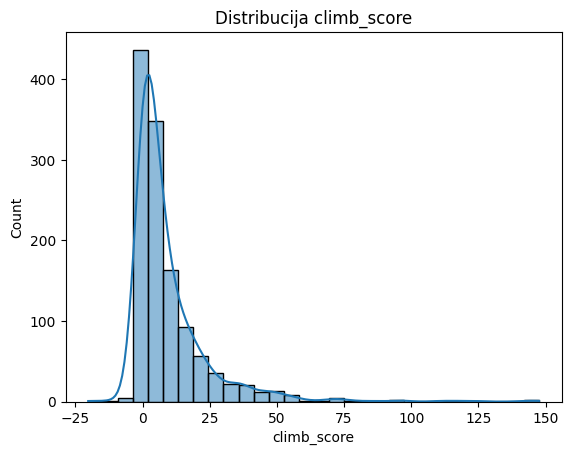

In [ ]:
df = pd.read_json("data/intermediate/cleaned_segments.json")

df["climb_score"] = (df["total_elevation_gain"] * df["average_grade"]) / 100

df["is_flat"] = df["average_grade"].abs() < 1.5
df_climbs = df[~df["is_flat"]].copy()

sns.histplot(df_climbs["climb_score"], bins=30, kde=True)
plt.title("Distribucija climb_score")
plt.show()


In [85]:
def custom_climb_category():
    """Dodeli kategorijo vzpona segmentom na podlagi fiksnih mej."""

    df = pd.read_json("data/intermediate/cleaned_segments.json")

    # Izračunaj climb_score
    df["climb_score"] = (df["total_elevation_gain"] * df["average_grade"]) / 100

    df["is_flat"] = df["climb_score"] < 0.05

    df_climbs = df[~df["is_flat"]].copy()

    bins = [-float("inf"), 4, 10, 20, 40, float("inf")]
    labels = [1, 2, 3, 4, 5]

    climb_categories = pd.cut(df_climbs["climb_score"], bins=bins, labels=labels, right=False)

    # Pretvori samo ne-NaN vrednosti
    climb_categories = climb_categories.astype("Int64")  # Pandas integer nullable

    df.loc[df_climbs.index, "custom_climb_category"] = climb_categories
    df.loc[df["is_flat"], "custom_climb_category"] = 0  # ravnina

    df.to_json("data/intermediate/segments_climb_category.json", orient="records")


In [86]:
custom_climb_category()

with open("data/intermediate/segments_climb_category.json") as f:
    segments_climb_category = json.load(f)

print(len(segments_climb_category))
print(segments_climb_category[0].keys())

with open("data/intermediate/segments_climb_category.json", "w") as f:
    json.dump(segments_climb_category, f, indent=4)

1526
dict_keys(['id', 'name', 'activity_type', 'distance', 'average_grade', 'maximum_grade', 'elevation_high', 'elevation_low', 'start_latlng', 'end_latlng', 'elevation_profile', 'elevation_profiles', 'country', 'total_elevation_gain', 'map', 'effort_count', 'kom', 'qom', 'climb_score', 'is_flat', 'custom_climb_category'])


In [87]:
categories_count = [0] * 6  # 0, 1, 2, 3, 4, 5
for segment in segments_climb_category:
    categories_count[int(segment['custom_climb_category'])] += 1

print("Število segmentov po kategorijah vzponov:")
for i in range(6):
    print(f"Kategorija {i}: {categories_count[i]}")


Število segmentov po kategorijah vzponov:
Kategorija 0: 468
Kategorija 1: 420
Kategorija 2: 275
Kategorija 3: 195
Kategorija 4: 116
Kategorija 5: 52


Še zadnji atributi, določitev regije segmenta. Podobno kot določanje države z datoteko `geojson` slovenskih občin segmentu določimo občine v katerih se nahaja glede na začetek in konec. Podatek bo lahko kasneje v analizi uporaben za primerjavo občin oziroma večjih regij.

In [88]:
with open("random/obcine.geojson") as f:
    data = json.load(f)

regions_geom = []
for region in data['features']:
    region_geom = {
        'name': region['properties']['name'],
        'geometry': shape(region['geometry'])
    }
    regions_geom.append(region_geom)

print(f"Število občin: {len(regions_geom)}")

Število občin: 212


In [89]:
def find_region(segments):
    """Najdi regijo za vsak segment."""
    for segment in segments:
        
        start = Point(segment['start_latlng'][1], segment['start_latlng'][0])
        end = Point(segment['end_latlng'][1], segment['end_latlng'][0])
        
        segment['region'] = []
        for region in regions_geom:
            if region['geometry'].contains(start) or region['geometry'].contains(end):
                segment['region'].append(region['name'])
    return segments

In [90]:
with open("data/intermediate/segments_climb_category.json") as f:
    segments_climb_category = json.load(f)

segments_with_region = find_region(segments_climb_category)

with open("data/clean/segments.json", "w") as f:
    json.dump(segments_with_region, f, indent=4)
    

In [91]:
print(segments_with_region[0].keys())
print(len(segments_with_region))

dict_keys(['id', 'name', 'activity_type', 'distance', 'average_grade', 'maximum_grade', 'elevation_high', 'elevation_low', 'start_latlng', 'end_latlng', 'elevation_profile', 'elevation_profiles', 'country', 'total_elevation_gain', 'map', 'effort_count', 'kom', 'qom', 'climb_score', 'is_flat', 'custom_climb_category', 'region'])
1526


"čisti" podatki so shranjeni v "data/clean/segments.json". Mogoče bomo naknadno ugotovili potrebo po še kakšnem atributu, a so zaenkrat ti ustrezni.

Atributi:
```'id', 'name', 'activity_type', 'distance', 'average_grade', 'maximum_grade', 'elevation_high', 'elevation_low', 'start_latlng', 'end_latlng', 'elevation_profile', 'elevation_profiles', 'country', 'total_elevation_gain', 'map', 'effort_count', 'kom', 'qom' ```